In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

<font color="#fff">Om Jai Shree Ganeshai Namah</font>

In [2]:
#!rm -r all_data

In [3]:
import tensorflow as tf
import imghdr
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np

#import urllib.request
#from PIL import Image
import imageio
import math

In [4]:
timg = cv2.imread("../input/dataset/val/OSCC/OSCC_100x_196.jpg")
timg.shape

(1536, 2048, 3)

In [5]:
!rm -r ./all_data

rm: cannot remove './all_data': No such file or directory


In [6]:
!mkdir -p all_data/Normal
!mkdir -p all_data/OSCC

In [7]:
!cp -r ../input/dataset/test/Normal ./all_data/
!cp -r ../input/dataset/test/OSCC ./all_data/

In [8]:
!cp -r ../input/dataset/train/Normal ./all_data/
!cp -r ../input/dataset/train/OSCC ./all_data/

In [9]:
!cp -r ../input/dataset/val/Normal ./all_data/
!cp -r ../input/dataset/val/OSCC ./all_data/

In [10]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2022-10-17 04:32:50.340774: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 04:32:50.440617: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 04:32:50.441420: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [11]:
data_dir = './all_data/'

In [12]:
"""
img_exts = ['jpeg', 'jpg', 'bmp', 'png']

class_name_arr = ['Normal', 'OSCC']

for classi in class_name_arr:
    for img in os.listdir(os.path.join(data_dir, classi)):
        img_path = data_dir + classi +'/'+img
        try : 
            imgcv = cv2.imread(img_path)
            img_ext = imghdr.what(img_path)
            if(img_ext not in img_exts):
                os.remove(img_path)
        except Exception as e:
            print("Issue with Image : {}".format(img_path))
            """

'\nimg_exts = [\'jpeg\', \'jpg\', \'bmp\', \'png\']\n\nclass_name_arr = [\'Normal\', \'OSCC\']\n\nfor classi in class_name_arr:\n    for img in os.listdir(os.path.join(data_dir, classi)):\n        img_path = data_dir + classi +\'/\'+img\n        try : \n            imgcv = cv2.imread(img_path)\n            img_ext = imghdr.what(img_path)\n            if(img_ext not in img_exts):\n                os.remove(img_path)\n        except Exception as e:\n            print("Issue with Image : {}".format(img_path))\n            '

In [13]:
import argparse
import numpy as np
from PIL import Image


def normalizeStaining(img, saveFile=None, Io=240, alpha=1, beta=0.15):
    ''' Normalize staining appearence of H&E stained images
    
    Example use:
        see test.py
        
    Input:
        I: RGB input image
        Io: (optional) transmitted light intensity
        
    Output:
        Inorm: normalized image
        H: hematoxylin image
        E: eosin image
    
    Reference: 
        A method for normalizing histology slides for quantitative analysis. M.
        Macenko et al., ISBI 2009
    '''
             
    HERef = np.array([[0.5626, 0.2159],
                      [0.7201, 0.8012],
                      [0.4062, 0.5581]])
        
    maxCRef = np.array([1.9705, 1.0308])
    
    # define height and width of image
    h, w, c = img.shape
    
    # reshape image
    img = img.reshape((-1,3))

    # calculate optical density
    OD = -np.log((img.astype(np.float)+1)/Io)
    
    # remove transparent pixels
    ODhat = OD[~np.any(OD<beta, axis=1)]
        
    # compute eigenvectors
    eigvals, eigvecs = np.linalg.eigh(np.cov(ODhat.T))
    
    #eigvecs *= -1
    
    #project on the plane spanned by the eigenvectors corresponding to the two 
    # largest eigenvalues    
    That = ODhat.dot(eigvecs[:,1:3])
    
    phi = np.arctan2(That[:,1],That[:,0])
    
    minPhi = np.percentile(phi, alpha)
    maxPhi = np.percentile(phi, 100-alpha)
    
    vMin = eigvecs[:,1:3].dot(np.array([(np.cos(minPhi), np.sin(minPhi))]).T)
    vMax = eigvecs[:,1:3].dot(np.array([(np.cos(maxPhi), np.sin(maxPhi))]).T)
    
    # a heuristic to make the vector corresponding to hematoxylin first and the 
    # one corresponding to eosin second
    if vMin[0] > vMax[0]:
        HE = np.array((vMin[:,0], vMax[:,0])).T
    else:
        HE = np.array((vMax[:,0], vMin[:,0])).T
    
    # rows correspond to channels (RGB), columns to OD values
    Y = np.reshape(OD, (-1, 3)).T
    
    # determine concentrations of the individual stains
    C = np.linalg.lstsq(HE,Y, rcond=None)[0]
    
    # normalize stain concentrations
    maxC = np.array([np.percentile(C[0,:], 99), np.percentile(C[1,:],99)])
    tmp = np.divide(maxC,maxCRef)
    C2 = np.divide(C,tmp[:, np.newaxis])
    
    # recreate the image using reference mixing matrix
    Inorm = np.multiply(Io, np.exp(-HERef.dot(C2)))
    Inorm[Inorm>255] = 254
    Inorm = np.reshape(Inorm.T, (h, w, 3)).astype(np.uint8)  
    
    # unmix hematoxylin and eosin
    H = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,0], axis=1).dot(np.expand_dims(C2[0,:], axis=0))))
    H[H>255] = 254
    H = np.reshape(H.T, (h, w, 3)).astype(np.uint8)
    
    E = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,1], axis=1).dot(np.expand_dims(C2[1,:], axis=0))))
    E[E>255] = 254
    E = np.reshape(E.T, (h, w, 3)).astype(np.uint8)
    
    if saveFile is not None:
        Image.fromarray(Inorm).save(saveFile+'.png')
        Image.fromarray(H).save(saveFile+'_H.png')
        Image.fromarray(E).save(saveFile+'_E.png')

    return Inorm, H, E


In [14]:
!rm -r processed_data
!mkdir -p processed_data/Normal
!mkdir -p processed_data/OSCC

rm: cannot remove 'processed_data': No such file or directory


In [15]:
imgcount = 0
data_dir = "all_data/Normal/"
dest_dir = "processed_data/Normal/"
for img in os.listdir(data_dir):
    path = data_dir+img
    path_save = dest_dir+img
    imgcv = cv2.imread(path)
    if(imgcv.shape == (1536, 2048, 3)):
        final_img = imgcv
    elif(imgcv.shape == (2048, 1536, 3)):
        newimg = cv2.rotate(imgcv, cv2.ROTATE_90_CLOCKWISE)
        final_img = newimg
    else:
        rsimg = cv2.resize(imgcv, (2048, 1536))
        final_img = rsimg
    Inorm, H, E = normalizeStaining(img = final_img)
    cv2.imwrite(path_save, Inorm)
    imgcount = imgcount + 1
    if(imgcount > 20):
        pass

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [16]:
imgcount = 0
data_dir = "all_data/OSCC/"
dest_dir = "processed_data/OSCC/"
for img in os.listdir(data_dir):
    path = data_dir+img
    path_save = dest_dir+img
    imgcv = cv2.imread(path)
    if(imgcv.shape == (1536, 2048, 3)):
        final_img = imgcv
    elif(imgcv.shape == (2048, 1536, 3)):
        newimg = cv2.rotate(imgcv, cv2.ROTATE_90_CLOCKWISE)
        final_img = newimg
    else:
        rsimg = cv2.resize(imgcv, (2048, 1536))
        final_img = rsimg
    Inorm, H, E = normalizeStaining(img = final_img)
    cv2.imwrite(path_save, Inorm)
    imgcount = imgcount + 1
    if(imgcount > 20):
        pass

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [17]:
imgs = 224*3
processed_data_dir = "processed_data"
data = tf.keras.utils.image_dataset_from_directory(processed_data_dir, image_size=(imgs, imgs), batch_size=4)

Found 5192 files belonging to 2 classes.


2022-10-17 06:47:14.108476: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-17 06:47:14.109041: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 06:47:14.109870: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 06:47:14.110501: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [18]:
scaled_data = data.map(lambda x,y : (x/255,y))
#scaled_data = data.map(preprocess)

In [19]:
data_iterator = scaled_data.as_numpy_iterator()

2022-10-17 06:47:16.853891: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [20]:
batch = data_iterator.next()

In [21]:
print(batch[0][1].min())
print(batch[0][1].max())

0.00042020652
1.0


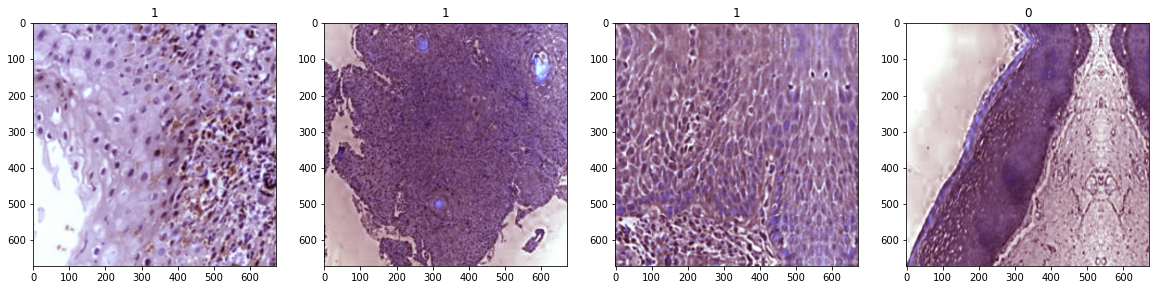

In [22]:
fig, ax =  plt.subplots(ncols = 4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [23]:
len(data) # 3170 = 32[batch_size] * 100[no_batches] approx.

1298

In [24]:
len(data)

1298

In [25]:
train_size = int(len(data)*0.7)
print("training images : {}".format(train_size*32))
val_size = int(len(data)*0.2)
print("validation images : {}".format(val_size*32))
test_size = int(len(data)*0.1)
print("test images : {}".format(test_size*32))


training images : 29056
validation images : 8288
test images : 4128


In [26]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [27]:
len(test)

129

In [28]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, MaxPool2D, AveragePooling2D, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import SGD,Adam
from keras.callbacks import LearningRateScheduler

In [29]:
"""
model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation="relu", input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(128, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(256, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dropout(0.2))

model.add(Dense(256, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
"""

'\nmodel = Sequential()\n\nmodel.add(Conv2D(16, (3,3), 1, activation="relu", input_shape=(256,256,3)))\nmodel.add(MaxPooling2D())\n\nmodel.add(Conv2D(32, (3,3), 1, activation="relu"))\nmodel.add(MaxPooling2D())\n\nmodel.add(Conv2D(64, (3,3), 1, activation="relu"))\nmodel.add(MaxPooling2D())\n\nmodel.add(Conv2D(128, (3,3), 1, activation="relu"))\nmodel.add(MaxPooling2D())\n\nmodel.add(Conv2D(256, (3,3), 1, activation="relu"))\nmodel.add(MaxPooling2D())\n\nmodel.add(Flatten())\n\nmodel.add(Dropout(0.2))\n\nmodel.add(Dense(256, activation="relu"))\nmodel.add(Dense(1, activation="sigmoid"))\n'

In [30]:
"""
baad model : 54% accuracy 
model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation="relu", input_shape=(imgs, imgs, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(128, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(256, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation="relu", kernel_regularizer  = L2(0.001)))
model.add(Dropout(0.2))

model.add(Dense(256, activation="relu", kernel_regularizer  = L2(0.001)))
model.add(Dropout(0.2))

model.add(Dense(1, activation="sigmoid"))
"""

'\nbaad model : 54% accuracy \nmodel = Sequential()\n\nmodel.add(Conv2D(16, (3,3), 1, activation="relu", input_shape=(imgs, imgs, 3)))\nmodel.add(MaxPooling2D())\n\nmodel.add(Conv2D(32, (3,3), 1, activation="relu"))\nmodel.add(MaxPooling2D())\n\nmodel.add(Conv2D(64, (3,3), 1, activation="relu"))\nmodel.add(MaxPooling2D())\n\nmodel.add(Conv2D(128, (3,3), 1, activation="relu"))\nmodel.add(MaxPooling2D())\n\nmodel.add(Conv2D(256, (3,3), 1, activation="relu"))\nmodel.add(MaxPooling2D())\n\nmodel.add(Flatten())\n\nmodel.add(Dense(256, activation="relu", kernel_regularizer  = L2(0.001)))\nmodel.add(Dropout(0.2))\n\nmodel.add(Dense(256, activation="relu", kernel_regularizer  = L2(0.001)))\nmodel.add(Dropout(0.2))\n\nmodel.add(Dense(1, activation="sigmoid"))\n'

In [31]:
"""
Best : 86% accuracy
model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation="relu", input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(128, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Dropout(0.2))

model.add(Conv2D(256, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(512, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(512, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
"""

'\nBest : 86% accuracy\nmodel = Sequential()\n\nmodel.add(Conv2D(16, (3,3), 1, activation="relu", input_shape=(256,256,3)))\nmodel.add(MaxPooling2D())\n\nmodel.add(Conv2D(32, (3,3), 1, activation="relu"))\nmodel.add(MaxPooling2D())\n\nmodel.add(Dropout(0.2))\n\nmodel.add(Conv2D(64, (3,3), 1, activation="relu"))\nmodel.add(MaxPooling2D())\n\nmodel.add(Conv2D(128, (3,3), 1, activation="relu"))\nmodel.add(MaxPooling2D())\n\nmodel.add(Dropout(0.2))\n\nmodel.add(Conv2D(256, (3,3), 1, activation="relu"))\nmodel.add(MaxPooling2D())\n\nmodel.add(Conv2D(512, (3,3), 1, activation="relu"))\nmodel.add(MaxPooling2D())\n\nmodel.add(Dropout(0.2))\n\nmodel.add(Flatten())\n\nmodel.add(Dense(512, activation="relu"))\nmodel.add(Dense(1, activation="sigmoid"))\n'

In [32]:
"""
model = Sequential()

model.add(Conv2D(32, (3,3), 1, activation="relu", padding="same", input_shape=(imgs, imgs, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), 1, activation="relu", padding="same"))
model.add(MaxPooling2D())

model.add(Conv2D(128, (3,3), 1, activation="relu", padding="same"))
model.add(MaxPooling2D())

model.add(Conv2D(256, (3,3), 1, activation="relu", padding="same"))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
"""


'\nmodel = Sequential()\n\nmodel.add(Conv2D(32, (3,3), 1, activation="relu", padding="same", input_shape=(imgs, imgs, 3)))\nmodel.add(MaxPooling2D())\n\nmodel.add(Conv2D(64, (3,3), 1, activation="relu", padding="same"))\nmodel.add(MaxPooling2D())\n\nmodel.add(Conv2D(128, (3,3), 1, activation="relu", padding="same"))\nmodel.add(MaxPooling2D())\n\nmodel.add(Conv2D(256, (3,3), 1, activation="relu", padding="same"))\nmodel.add(MaxPooling2D())\n\nmodel.add(Flatten())\n\nmodel.add(Dense(256, activation="relu"))\nmodel.add(Dense(1, activation="sigmoid"))\n'

In [33]:
#vgg : Sticking to 51% even after 25 epochs

"""
model = Sequential()
model.add(Conv2D(input_shape=(imgs, imgs, 3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))

model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))

model.add(Dense(units=1, activation="sigmoid"))
"""

'\nmodel = Sequential()\nmodel.add(Conv2D(input_shape=(imgs, imgs, 3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))\n\nmodel.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))\nmodel.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))\n\nmodel.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))\nmodel.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))\nmodel.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))\n\nmodel.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))\nmodel.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))\nmodel.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))\nmodel.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))\n\nmodel.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))\nmodel.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))\nmodel.add(Co

In [34]:
""""
model = Sequential()

model.add(Conv2D(64, (3,3), 1, activation="relu", input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(128, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Dropout(0.2))

model.add(Conv2D(256, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(512, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Dropout(0.2))

model.add(Conv2D(1024, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(2048, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(2048, activation="relu"))

model.add(Dense(1, activation="sigmoid"))
"""


'"\nmodel = Sequential()\n\nmodel.add(Conv2D(64, (3,3), 1, activation="relu", input_shape=(256,256,3)))\nmodel.add(MaxPooling2D())\n\nmodel.add(Conv2D(128, (3,3), 1, activation="relu"))\nmodel.add(MaxPooling2D())\n\nmodel.add(Dropout(0.2))\n\nmodel.add(Conv2D(256, (3,3), 1, activation="relu"))\nmodel.add(MaxPooling2D())\n\nmodel.add(Conv2D(512, (3,3), 1, activation="relu"))\nmodel.add(MaxPooling2D())\n\nmodel.add(Dropout(0.2))\n\nmodel.add(Conv2D(1024, (3,3), 1, activation="relu"))\nmodel.add(MaxPooling2D())\n\nmodel.add(Conv2D(2048, (3,3), 1, activation="relu"))\nmodel.add(MaxPooling2D())\n\nmodel.add(Flatten())\nmodel.add(Dense(2048, activation="relu"))\n\nmodel.add(Dense(1, activation="sigmoid"))\n'

In [35]:
"""
model = Sequential()

model.add(Conv2D(16, (3,3), activation="relu", input_shape=(imgs, imgs, 3)))
model.add(AveragePooling2D())

model.add(Conv2D(32, (3,3), activation="relu"))
model.add(AveragePooling2D())

model.add(Conv2D(64, (3,3), activation="relu"))
model.add(AveragePooling2D())

#model.add(Dropout(0.5))

model.add(Conv2D(64, (3,3), activation="relu"))
model.add(AveragePooling2D())
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))
"""


'\nmodel = Sequential()\n\nmodel.add(Conv2D(16, (3,3), activation="relu", input_shape=(imgs, imgs, 3)))\nmodel.add(AveragePooling2D())\n\nmodel.add(Conv2D(32, (3,3), activation="relu"))\nmodel.add(AveragePooling2D())\n\nmodel.add(Conv2D(64, (3,3), activation="relu"))\nmodel.add(AveragePooling2D())\n\n#model.add(Dropout(0.5))\n\nmodel.add(Conv2D(64, (3,3), activation="relu"))\nmodel.add(AveragePooling2D())\nmodel.add(Dropout(0.5))\n\nmodel.add(Flatten())\n\nmodel.add(Dense(128, activation="relu"))\nmodel.add(Dropout(0.5))\nmodel.add(Dense(1, activation="sigmoid"))\n'

In [36]:
"""

model = Sequential()

model.add(Conv2D(16, (3,3), activation="relu", input_shape=(imgs, imgs, 3), padding="same"))
model.add(AveragePooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(32, (3,3), activation="relu", padding="same"))
model.add(AveragePooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), activation="relu", padding="same"))
model.add(AveragePooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), activation="relu", padding="same"))
model.add(AveragePooling2D())
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))"""

'\n\nmodel = Sequential()\n\nmodel.add(Conv2D(16, (3,3), activation="relu", input_shape=(imgs, imgs, 3), padding="same"))\nmodel.add(AveragePooling2D())\nmodel.add(Dropout(0.2))\n\nmodel.add(Conv2D(32, (3,3), activation="relu", padding="same"))\nmodel.add(AveragePooling2D())\nmodel.add(Dropout(0.2))\n\nmodel.add(Conv2D(64, (3,3), activation="relu", padding="same"))\nmodel.add(AveragePooling2D())\nmodel.add(Dropout(0.2))\n\nmodel.add(Conv2D(64, (3,3), activation="relu", padding="same"))\nmodel.add(AveragePooling2D())\nmodel.add(Dropout(0.2))\n\nmodel.add(Flatten())\n\nmodel.add(Dense(64, activation="relu"))\nmodel.add(Dropout(0.2))\nmodel.add(Dense(64, activation="relu"))\nmodel.add(Dropout(0.2))\nmodel.add(Dense(1, activation="sigmoid"))'

In [37]:
"""
#vgg architecture 
model = Sequential()
model.add(Conv2D(input_shape=(imgs,imgs,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=1, activation="sigmoid"))
"""

'\n#vgg architecture \nmodel = Sequential()\nmodel.add(Conv2D(input_shape=(imgs,imgs,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))\nmodel.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))\nmodel.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))\n\nmodel.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))\nmodel.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))\nmodel.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))\n\nmodel.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))\nmodel.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))\nmodel.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))\nmodel.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))\n\nmodel.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))\nmodel.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"

In [38]:
"""
#AlexNet Architecture
model = Sequential()

model.add(Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(imgs,imgs,3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3,3), strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3,3), strides=(2,2)))

model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3,3), strides=(2,2)))

model.add(Flatten())

model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))"""


'\n#AlexNet Architecture\nmodel = Sequential()\n\nmodel.add(Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation=\'relu\', input_shape=(imgs,imgs,3)))\nmodel.add(BatchNormalization())\nmodel.add(MaxPool2D(pool_size=(3,3), strides=(2,2)))\n\nmodel.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation=\'relu\', padding="same"))\nmodel.add(BatchNormalization())\nmodel.add(MaxPool2D(pool_size=(3,3), strides=(2,2)))\n\nmodel.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation=\'relu\', padding="same"))\nmodel.add(BatchNormalization())\n\nmodel.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation=\'relu\', padding="same"))\nmodel.add(BatchNormalization())\n\nmodel.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation=\'relu\', padding="same"))\nmodel.add(BatchNormalization())\nmodel.add(MaxPool2D(pool_size=(3,3), strides=(2,2)))\n\nmodel.add(Flatten())\n\nmodel.add(Dense(4096, activation=\'relu\'))\nmodel.add(Dropout

In [39]:
resnet_model = Sequential()

#ResNet50
pretrained_model= tf.keras.applications.DenseNet201(include_top=False,
                   input_shape=(imgs,imgs,3),
                   pooling='avg',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

74850304/74836368 [==============================] - 0s 0us/step


In [40]:
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(1, activation='sigmoid'))

In [41]:
model = resnet_model

In [42]:
#model.compile(Adam(learning_rate=0.001),  loss=tf.losses.BinaryCrossentropy() , metrics=['accuracy'])
model.compile("adam", loss=tf.losses.BinaryCrossentropy() , metrics=['accuracy'])

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 1920)              18321984  
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               983552    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 19,306,049
Trainable params: 984,065
Non-trainable params: 18,321,984
_________________________________________________________________


In [44]:
!mkdir logs

logdir = './logs'

In [45]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

2022-10-17 06:47:27.089598: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-17 06:47:27.089709: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-10-17 06:47:27.092001: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-10-17 06:47:27.332607: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-10-17 06:47:27.332798: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [46]:
hist = model.fit(train, epochs = 50, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/50


2022-10-17 06:47:38.158600: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


  1/908 [..............................] - ETA: 4:22:59 - loss: 1.5517 - accuracy: 0.5000

2022-10-17 06:47:45.517126: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-17 06:47:45.517178: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/908 [..............................] - ETA: 12:11 - loss: 2.6477 - accuracy: 0.5000  

2022-10-17 06:47:46.024349: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-10-17 06:47:46.025665: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-10-17 06:47:46.181807: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 1090 callback api events and 1087 activity events. 
2022-10-17 06:47:46.212280: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-10-17 06:47:46.254052: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2022_10_17_06_47_46

2022-10-17 06:47:46.275694: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2022_10_17_06_47_46/fd4cba67157e.trace.json.gz
2022-10-17 06:47:46.337021: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/tr

908/908 [==============================] - 264s 272ms/step - loss: 0.8371 - accuracy: 0.6324 - val_loss: 0.5746 - val_accuracy: 0.7017
Epoch 2/50
908/908 [==============================] - 244s 268ms/step - loss: 0.5767 - accuracy: 0.7073 - val_loss: 0.6270 - val_accuracy: 0.6670
Epoch 3/50
908/908 [==============================] - 186s 204ms/step - loss: 0.5490 - accuracy: 0.7219 - val_loss: 0.4842 - val_accuracy: 0.7770
Epoch 4/50
908/908 [==============================] - 186s 204ms/step - loss: 0.5257 - accuracy: 0.7461 - val_loss: 0.5123 - val_accuracy: 0.7529
Epoch 5/50
908/908 [==============================] - 244s 269ms/step - loss: 0.4998 - accuracy: 0.7508 - val_loss: 0.4588 - val_accuracy: 0.7876
Epoch 6/50
908/908 [==============================] - 187s 205ms/step - loss: 0.4803 - accuracy: 0.7682 - val_loss: 0.4651 - val_accuracy: 0.7867
Epoch 7/50
908/908 [==============================] - 245s 269ms/step - loss: 0.4486 - accuracy: 0.7872 - val_loss: 0.4438 - val_accura

In [47]:
hist.history

{'loss': [0.8370717763900757,
  0.5767407417297363,
  0.5490332245826721,
  0.5256808996200562,
  0.4997934401035309,
  0.4802510142326355,
  0.44858410954475403,
  0.43599000573158264,
  0.41518303751945496,
  0.4024728536605835,
  0.388333797454834,
  0.3757961094379425,
  0.37108343839645386,
  0.35314834117889404,
  0.3470490872859955,
  0.3465248942375183,
  0.3308928608894348,
  0.31135067343711853,
  0.30871012806892395,
  0.29885202646255493,
  0.29223009943962097,
  0.27530935406684875,
  0.2751966714859009,
  0.27869635820388794,
  0.2676243484020233,
  0.24526812136173248,
  0.24833454191684723,
  0.2467152327299118,
  0.23996223509311676,
  0.2258712202310562,
  0.23122209310531616,
  0.22192977368831635,
  0.20062480866909027,
  0.2012680023908615,
  0.19931519031524658,
  0.21133756637573242,
  0.19330719113349915,
  0.18819819390773773,
  0.18260684609413147,
  0.1854819804430008,
  0.1797887086868286,
  0.17492303252220154,
  0.16868865489959717,
  0.16292811930179596,


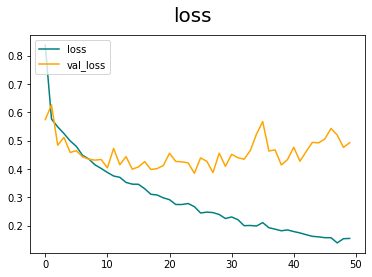

In [48]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

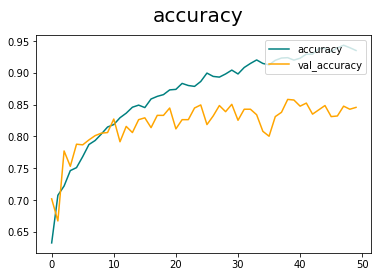

In [49]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('accuracy', fontsize=20)
plt.legend(loc='upper right')
plt.show()

In [50]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [51]:
len(test)

129

In [52]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [53]:
print(f'Precision : {pre.result().numpy()}, Recall: {re.result().numpy()}. Accuracy : {acc.result().numpy()}')

Precision : 0.8861788511276245, Recall: 0.8104089498519897. Accuracy : 0.8468992114067078


In [54]:
#tomurl = 'https://i.pinimg.com/474x/92/a6/2f/92a62f0221f58fe503a15fcb13f5c107--tom-jerry-movies-.jpg'
#jerryurl = 'https://www.meme-arsenal.com/memes/2774744123cafbceb2c1f2aa14c65d82.jpg'

In [55]:
#import requests
#from io import BytesIO

In [56]:
#res = requests.get(tomurl)
#res.content()

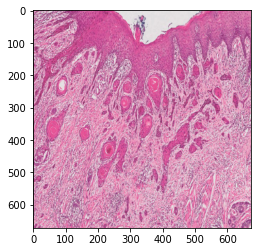

In [57]:
osccpath = "https://media.springernature.com/m685/springer-static/image/art%3A10.1038%2Fsj.bdj.2018.926/MediaObjects/41415_2018_Article_BFsjbdj2018926_Fig1_HTML.jpg"
osccimg  = imageio.v2.imread(osccpath)
osccimg = cv2.resize(osccimg, (imgs, imgs))
osccimg = osccimg/255
plt.imshow(osccimg)
plt.show()

In [58]:
oscc_batch = np.expand_dims(osccimg, 0)

yhat = model.predict(oscc_batch)
print(yhat)

[[2.0073542e-11]]


In [59]:
if yhat < 0.5:
    print("Predicted class is Normal")
else:
    print("Predicted class is OSCC")

Predicted class is Normal


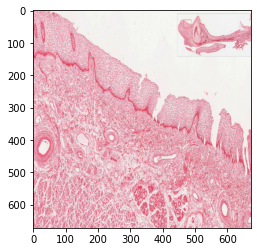

In [60]:
normalpath = "https://histology.medicine.umich.edu/sites/default/files/images/slides/9oral.jpg"
nimg  = imageio.v2.imread(normalpath)
nimg = cv2.resize(nimg, (imgs, imgs))
nimg = nimg/255
plt.imshow(nimg)
plt.show()

In [61]:
nimg_batch = np.expand_dims(nimg, 0)
yhat = model.predict(nimg_batch)
print(yhat)

if yhat < 0.5:
    print("Predicted class is Normal")
else:
    print("Predicted class is OSCC")

[[3.0015456e-14]]
Predicted class is Normal


In [62]:
from tensorflow.keras.models import load_model

In [63]:
!mkdir("models")

model.save(f'models/on_{acc.result().numpy()}.h5')

/bin/bash: -c: line 0: syntax error near unexpected token `"models"'
/bin/bash: -c: line 0: `mkdir("models")'


In [64]:
ldmodel = load_model(f'models/on_{acc.result().numpy()}.h5')

In [65]:
yhat = ldmodel.predict(nimg_batch)
if yhat < 0.5:
    print("Predicted class is Normal")
else:
    print("Predicted class is OSCC")

Predicted class is Normal
